# Lab04: Perceptron & Adaline
----
111062117 黃祥陞

Implement the Adaline with SGD which can set different batch_size ($M$) as parameter. Then, use the Iris dataset to fit your model with 3 different M(including $M=1$) and fixed learning rate $\eta$ and print out the accuracy of each model. Last, plot the cost against the number of epochs using different $M$ in one figure.

## 1. Split training and testing data (test_size = 20% of the whole dataset)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


## 2. Handcrafted Adaline classifier with M as parameter

In [2]:
class AdalineSGD:
    def __init__(self, eta=0.01, n_iter=10, M=1, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.M = M # mini-batch size
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            cost = 0
            for Xb, yb in self._shuffle(X, y):
                cost += self._update_weights(Xb, yb)
            self.cost_.append(cost)
        return self

    def _shuffle(self, X, y):
        r = np.random.RandomState(self.random_state)
        indices = np.arange(X.shape[0])
        r.shuffle(indices)
        # yield mini-batch indices
        for start_idx in range(0, indices.shape[0] - self.M + 1, self.M):
            excerpt = indices[start_idx:start_idx + self.M]
            yield X[excerpt], y[excerpt]
        # if the number of samples is not divisible by M
        if indices.shape[0] % self.M != 0:
            excerpt = indices[-(indices.shape[0] % self.M):]
            yield X[excerpt], y[excerpt]

    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)

    def _update_weights(self, Xb, yb):
        output = self.activation(Xb)
        errors = (yb - output)
        batch_size = Xb.shape[0]
        self.w_[1:] += self.eta * Xb.T.dot(errors) / batch_size
        self.w_[0] += self.eta * errors.sum() / batch_size
        cost = 0.5 * (errors**2).sum()
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

## 3. Fit model with 3 different M and fixed η. (including M=1)

In [3]:
# Define the learning rate and number of iterations
eta = 0.01
n_iter = 25

# Define the different batch sizes
batch_sizes = [1, 4, 8]

# Fit the model with different batch sizes
adaline_models = {}
for M in batch_sizes:
    adaline = AdalineSGD(eta=eta, n_iter=n_iter, M=M, random_state=1)
    adaline.fit(X_train_std, y_train)
    adaline_models[M] = adaline
    print(f'Batch size: {M}, Cost: {adaline.cost_}')

Batch size: 1, Cost: [20.92543207421624, 11.589535003859584, 10.996341365362921, 10.90383320637934, 10.859697099014896, 10.829836839122537, 10.808190917854866, 10.792211527012883, 10.78034564907102, 10.771516687232259, 10.76494342330103, 10.760049441101081, 10.75640670819421, 10.753696544434455, 10.751681416432035, 10.750184189904381, 10.74907275080737, 10.748248565340933, 10.747638154883425, 10.74718673727966, 10.746853481717473, 10.746607966911668, 10.746427537222694, 10.746295329070017, 10.74619879779776]
Batch size: 4, Cost: [32.01310978579204, 21.05578196696714, 15.786259532637523, 13.243446876768298, 12.009214978229961, 11.404047399768707, 11.102099341736482, 10.946945206022178, 10.863364796086852, 10.81509492967422, 10.78458522983771, 10.763290675321928, 10.747011847906169, 10.733654788156551, 10.722151710398316, 10.711939371860188, 10.70270581708244, 10.694266618321418, 10.686503834276673, 10.679335506879076, 10.672700139193084, 10.666548599804122, 10.66083976175979, 10.6555380

## 4. Print the accuracy of each model

In [4]:
from sklearn.metrics import accuracy_score

for M, model in adaline_models.items():
    y_pred = model.predict(X_test_std)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Batch size: {M}, Accuracy: {accuracy:.2f}')

Batch size: 1, Accuracy: 0.85
Batch size: 4, Accuracy: 0.85
Batch size: 8, Accuracy: 0.85


## 5. Plot the cost against the number of epochs using different M in one figure

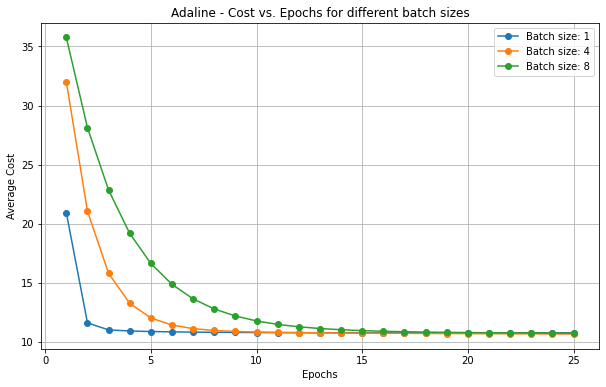

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for M, model in adaline_models.items():
    plt.plot(range(1, len(model.cost_) + 1), model.cost_, marker='o', label=f'Batch size: {M}')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.legend(loc='upper right')
plt.title('Adaline - Cost vs. Epochs for different batch sizes')
plt.grid(True)
plt.savefig('Lab04-1_111062117.png')
plt.show()